<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model.
5. Assess expected accuracy and tune your models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

In [1]:
import pandas as pd
# Training dataset
data=pd.read_csv('mimic_train.csv')
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [2]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('mimic_test_death.csv')
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [3]:
# Sample output prediction file
pred_sample=pd.read_csv('mimic_kaggle_death_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0
4908,200044,0
829,200049,0
4378,200063,0
4946,200081,0


In [4]:
# Your code here

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
import scipy

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score, confusion_matrix
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import category_encoders as encoders

#create X and y test and y train

y_train = data['HOSPITAL_EXPIRE_FLAG']
X_train = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1) 
X_test = data_test.copy()

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [6]:
#dates transformation
from datetime import datetime, timedelta

# Define a function get the diffrence in days bewteen two dates:
def date_difference(date_str):
    date_obj1 = datetime.strptime(date_str['DOB'], '%Y-%m-%d %H:%M:%S')
    date_obj2 = datetime.strptime(date_str['ADMITTIME'], '%Y-%m-%d %H:%M:%S')
    delta = date_obj2 - date_obj1
    return (delta.days) /365

X_train['age'] = X_train.apply(date_difference, axis=1)
X_test['age'] = X_test.apply(date_difference, axis=1)

# Clip the 'age' values to a maximum of 100
X_train['age'] = X_train['age'].apply(lambda x: np.clip(x, None, 100))
X_test['age'] = X_test['age'].apply(lambda x: np.clip(x, None, 100))


from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import feature_importances
cnames_numeric=list(X_train.select_dtypes(exclude =['object']).columns)
cnames_numeric

feature_importances(DecisionTreeClassifier(), data[cnames_numeric], y_train.astype(int))

In [7]:
#drop id variables and categorical variables
list_drop_train = ['subject_id','hadm_id','icustay_id','DOD','ADMITTIME', 'DISCHTIME', 'DEATHTIME'
                        , 'LOS', 'Diff', 'DOB']

list_drop_test = ['subject_id','hadm_id','icustay_id','ADMITTIME'
                        , 'Diff', 'DOB']
X_train = X_train.drop(list_drop_train, axis=1)
X_test = X_test.drop(list_drop_test, axis=1)

#Get column names of vategorical and numeric variables
#cnames_numeric=list(X_train.select_dtypes(exclude=['object']).columns)

#lists of numeric and categorical columns
cnames_categorical=list(X_train.select_dtypes(include =['object']).columns)
cnames_categorical

cnames_numeric=list(X_train.select_dtypes(exclude =['object']).columns)
cnames_numeric

#insurance dummy
#X_train= pd.get_dummies(X_train, prefix = ['INSURANCE'], columns = ['INSURANCE'], drop_first = True)
#X_test = pd.get_dummies(X_test, prefix = ['INSURANCE'], columns = ['INSURANCE'], drop_first = True)
#Admission dummy
#X_train= pd.get_dummies(X_train, prefix = ['ADMISSION_TYPE'], columns = ['ADMISSION_TYPE'], drop_first = True)
#X_test = pd.get_dummies(X_test, prefix = ['ADMISSION_TYPE'], columns = ['ADMISSION_TYPE'], drop_first = True

['HeartRate_Min',
 'HeartRate_Max',
 'HeartRate_Mean',
 'SysBP_Min',
 'SysBP_Max',
 'SysBP_Mean',
 'DiasBP_Min',
 'DiasBP_Max',
 'DiasBP_Mean',
 'MeanBP_Min',
 'MeanBP_Max',
 'MeanBP_Mean',
 'RespRate_Min',
 'RespRate_Max',
 'RespRate_Mean',
 'TempC_Min',
 'TempC_Max',
 'TempC_Mean',
 'SpO2_Min',
 'SpO2_Max',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'Glucose_Mean',
 'age']

for var in ['ETHNICITY', 'RELIGION', 'MARITAL_STATUS']:
    # Calculate the frequency of each category in the column
    category_counts_train = X_train[var].value_counts()
    category_counts_test = X_test[var].value_counts()
    # Calculate the threshold for "other" based on 5% of the total count
    threshold_train = 0.05 * len(X_train)
    threshold_test = 0.05 * len(X_test)
    # Identify categories that appear less than the threshold
    infrequent_categories_train = category_counts_train[category_counts_train < threshold_train].index
    infrequent_categories_test = category_counts_test[category_counts_test < threshold_test].index
    # Replace infrequent categories with 'other'
    X_train[var] = X_train[var].apply(lambda x: 'other' if x in infrequent_categories_train else x)
    X_test[var] = X_test[var].apply(lambda x: 'other' if x in infrequent_categories_test else x)

for var in ['ICD9_diagnosis', 'DIAGNOSIS']:
    # Calculate the frequency of each category in the column
    category_counts_train = X_train[var].value_counts()
    category_counts_test = X_test[var].value_counts()
    # Calculate the threshold for "other" based on 5% of the total count
    threshold_train = 0.01 * len(X_train)
    threshold_test = 0.01 * len(X_test)
    # Identify categories that appear less than the threshold
    infrequent_categories_train = category_counts_train[category_counts_train < threshold_train].index
    infrequent_categories_test = category_counts_test[category_counts_test < threshold_test].index
    # Replace infrequent categories with 'other'
    X_train[var] = X_train[var].apply(lambda x: 'other' if x in infrequent_categories_train else x)
    X_test[var] = X_test[var].apply(lambda x: 'other' if x in infrequent_categories_test else x)

print(X_train['ETHNICITY'].unique())
print(X_test['ETHNICITY'].unique())
print(X_train['DIAGNOSIS'].unique())
print(X_test['DIAGNOSIS'].unique())

In [8]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create a subset of X_train and X_test with the specified columns
X_train_subset = X_train[cnames_categorical]
X_test_subset = X_test[cnames_categorical]

#Impute categorical variables

imp_frequent = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imp_frequent.fit(X_train_subset) #use train mode!

X_train_subset = pd.DataFrame(imp_frequent.transform(X_train_subset), columns = cnames_categorical)
X_test_subset = pd.DataFrame(imp_frequent.transform(X_test_subset), columns = cnames_categorical)

# Update the original DataFrames with the imputed values
X_train[cnames_categorical] = X_train_subset
X_test[cnames_categorical] = X_test_subset

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
MeanBP_Min        2186
MeanBP_Max        2186
MeanBP_Mean       2186
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
TempC_Min         2497
TempC_Max         2497
TempC_Mean        2497
SpO2_Min          2203
SpO2_Max          2203
SpO2_Mean         2203
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
GENDER               0
ADMISSION_TYPE       0
INSURANCE            0
RELIGION             0
MARITAL_STATUS       0
ETHNICITY            0
DIAGNOSIS            0
ICD9_diagnosis       0
FIRST_CAREUNIT       0
age                  0
dtype: int64
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_

In [9]:
#Check for Nan
Nulls_train = X_train.isnull().sum()
Nulls_test = X_test.isnull().sum()

# We have to check both X_train and X_test

print(Nulls_train)
print(Nulls_test)

# Identifying Columns with Null variables
missing_data_col_X_train = X_train.columns[Nulls_train>0]
missing_data_col_X_test = X_test.columns[Nulls_test>0]
missing_data_col_X_train
missing_data_col_X_test

HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
MeanBP_Min        2186
MeanBP_Max        2186
MeanBP_Mean       2186
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
TempC_Min         2497
TempC_Max         2497
TempC_Mean        2497
SpO2_Min          2203
SpO2_Max          2203
SpO2_Mean         2203
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
GENDER               0
ADMISSION_TYPE       0
INSURANCE            0
RELIGION             0
MARITAL_STATUS       0
ETHNICITY            0
DIAGNOSIS            0
ICD9_diagnosis       0
FIRST_CAREUNIT       0
age                  0
dtype: int64
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean'],
      dtype='object')

In [10]:
#Apply one-hot encoding

categorical_cols_target = cnames_categorical.copy()
categorical_cols_hot = cnames_categorical.copy()


#categorical_cols_hot = ['MARITAL_STATUS', 'GENDER', 'ADMISSION_TYPE', 'RELIGION', 'ETHNICITY', 'FIRST_CAREUNIT', 'INSURANCE']
#categorical_cols_target = ['ICD9_diagnosis', 'DIAGNOSIS']

#for col in cnames_categorical:
    #X_train = pd.get_dummies(X_train, prefix=[col], columns=[col], drop_first=True)
    #X_test = pd.get_dummies(X_test, prefix=[col], columns=[col], drop_first=True)
    
#X_test.columns

#lists of numeric and categorical columns
#cnames_categorical=list(pd.DataFrame(X_train).select_dtypes(include =['object']).columns)
#cnames_categorical

# Load the CatBoost Encoder 
from category_encoders import TargetEncoder

categorical_cols = cnames_categorical
Target = 'HOSPITAL_EXPIRE_FLAG'
for col in categorical_cols:
    te = TargetEncoder()
    # fit the data
    te.fit(X = X_train[col], y = y_train)
    # transform
    values_train = te.transform(X_train[col])
    values_test = te.transform(X_test[col])
    X_train[col] = values_train
    X_test[col] = values_test

X_train.head()   

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,age
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0.115823,0.125554,0.134494,0.105340,0.081218,0.110177,0.071429,0.097436,0.139468,69.608219
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0.115823,0.125554,0.085989,0.190099,0.121702,0.110177,0.096354,0.097673,0.139468,42.101370
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0.115823,0.125554,0.134494,0.105340,0.108333,0.092059,0.089189,0.145399,0.139468,68.210959
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0.115823,0.032654,0.134494,0.099296,0.137637,0.110177,0.093420,0.075025,0.116637,74.961644
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.115823,0.125554,0.134494,0.127174,0.137637,0.110177,0.146259,0.025200,0.106994,79.424658


#feature selection
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
X, y = load_digits(return_X_y=True)
X.shape
se = SelectKBest(chi2, k=25)
se.fit(X_train, y_train)
X_train = se.transform(X_train)
X_test = se.transform(X_test)
#View data
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)
X_train.shape

In [11]:
#I'm going to try imputation by mean on both train-test sets instead of removing cols (numeric variables)

#imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean = KNNImputer(n_neighbors=15)

imp_mean.fit(X_train[cnames_numeric]) #use train set!

X_train = pd.DataFrame(imp_mean.transform(X_train[cnames_numeric]), columns = cnames_numeric)
X_test = pd.DataFrame(imp_mean.transform(X_test[cnames_numeric]), columns = cnames_numeric)

#Check if imputation was done correctly
print(X_train.isnull().sum())
print(X_test.isnull().sum())

HeartRate_Min     0
HeartRate_Max     0
HeartRate_Mean    0
SysBP_Min         0
SysBP_Max         0
SysBP_Mean        0
DiasBP_Min        0
DiasBP_Max        0
DiasBP_Mean       0
MeanBP_Min        0
MeanBP_Max        0
MeanBP_Mean       0
RespRate_Min      0
RespRate_Max      0
RespRate_Mean     0
TempC_Min         0
TempC_Max         0
TempC_Mean        0
SpO2_Min          0
SpO2_Max          0
SpO2_Mean         0
Glucose_Min       0
Glucose_Max       0
Glucose_Mean      0
age               0
dtype: int64
HeartRate_Min     0
HeartRate_Max     0
HeartRate_Mean    0
SysBP_Min         0
SysBP_Max         0
SysBP_Mean        0
DiasBP_Min        0
DiasBP_Max        0
DiasBP_Mean       0
MeanBP_Min        0
MeanBP_Max        0
MeanBP_Mean       0
RespRate_Min      0
RespRate_Max      0
RespRate_Mean     0
TempC_Min         0
TempC_Max         0
TempC_Mean        0
SpO2_Min          0
SpO2_Max          0
SpO2_Mean         0
Glucose_Min       0
Glucose_Max       0
Glucose_Mean      0
age    

In [12]:
X_train.columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age'],
      dtype='object')

# Replace the encoded columns in the train data sets
X_train = X_train.drop(categorical_cols, axis=1)
X_train = pd.concat ([X_train, encoded_df_train], axis=1)

# Replace the imputed columns in the test data sets
X_test = X_test.drop(categorical_cols, axis=1)
X_test = pd.concat ([X_test, encoded_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(X_train.shape))
print('Shape of the Test data set : {}'.format(X_test.shape))

In [13]:
#Get the common column names
common_columns = list(set(X_train.columns).intersection(X_test.columns))

#Create new dataframes with only the common columns
X_train = X_train[common_columns]
X_test = X_test[common_columns]

In [14]:
#Here I scale data

scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
scaler.fit(X_train) ## fit it to the train set
#Scale both sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#View data
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)

best parameters: {'metric': 'manhattan', 'n_neighbors': 300, 'weights': 'distance'}
best score:      0.77043 (+/-0.02472)


,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
55,manhattan,300,distance,"{'metric': 'manhattan', 'n_neighbors': 300, 'w...",0.746900,0.772065,0.762033,0.744096,0.789603,0.742972,0.827022,0.783268,0.756094,0.780198,0.770425,0.024719,1
54,manhattan,300,uniform,"{'metric': 'manhattan', 'n_neighbors': 300, 'w...",0.747380,0.770889,0.761896,0.742359,0.787639,0.741784,0.825529,0.786009,0.754709,0.778805,0.769700,0.024697,2
53,manhattan,250,distance,"{'metric': 'manhattan', 'n_neighbors': 250, 'w...",0.741468,0.771897,0.761094,0.742278,0.788949,0.740197,0.827276,0.780094,0.758734,0.777686,0.768967,0.025437,3
52,manhattan,250,uniform,"{'metric': 'manhattan', 'n_neighbors': 250, 'w...",0.741081,0.770756,0.761016,0.739914,0.787755,0.738652,0.825403,0.782326,0.758175,0.775601,0.768068,0.025448,4
49,manhattan,180,distance,"{'metric': 'manhattan', 'n_neighbors': 180, 'w...",0.738321,0.774762,0.754548,0.741442,0.784156,0.736748,0.828587,0.782480,0.760073,0.779138,0.768026,0.026679,5
51,manhattan,200,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'w...",0.736971,0.776430,0.759017,0.745865,0.784152,0.734939,0.826829,0.780173,0.757360,0.778264,0.768000,0.026050,6
48,manhattan,180,uniform,"{'metric': 'manhattan', 'n_neighbors': 180, 'w...",0.737359,0.774201,0.754075,0.738805,0.782313,0.735055,0.827445,0.786139,0.758993,0.777266,0.767165,0.027086,7
50,manhattan,200,uniform,"{'metric': 'manhattan', 'n_neighbors': 200, 'w...",0.735841,0.775961,0.758865,0.743920,0.782323,0.732825,0.824958,0.783093,0.756005,0.776203,0.767000,0.026223,8
47,manhattan,150,distance,"{'metric': 'manhattan', 'n_neighbors': 150, 'w...",0.742090,0.775134,0.750201,0.741224,0.782416,0.735103,0.826331,0.777686,0.759967,0.775872,0.766602,0.025786,9
25,minkowski,250,distance,"{'metric': 'minkowski', 'n_neighbors': 250, 'w...",0.756437,0.767344,0.756680,0.745835,0.781468,0.739383,0.814891,0.769657,0.746298,0.778306,0.765630,0.021157,10


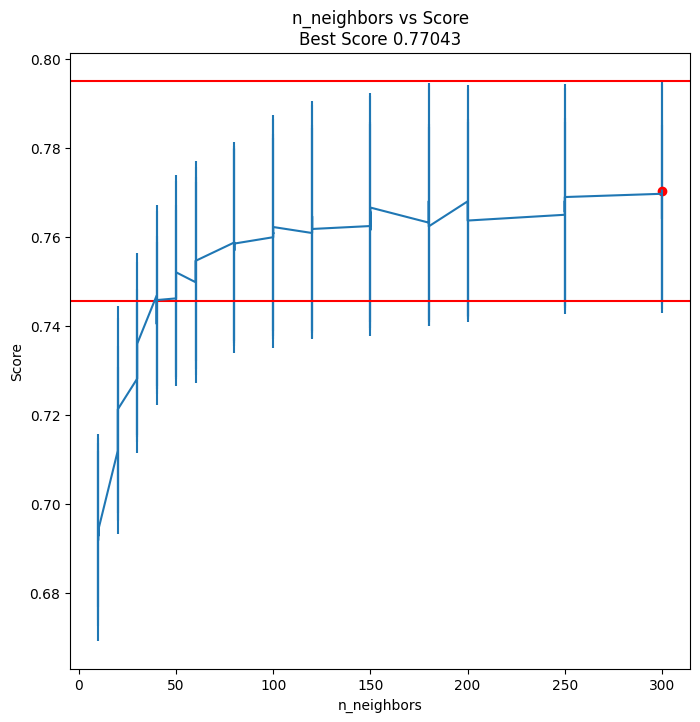

In [15]:
#Knn model

MyKNN = KNeighborsClassifier(algorithm = 'auto')

##Specify grid values for CV

grid_values = {'n_neighbors':[10, 20, 30, 40, 50, 60, 80, 100, 120, 150, 180, 200, 250, 300], 'weights':['uniform','distance'], 'metric':['minkowski','manhattan']}

#Grid Search
from sklearn.model_selection import GridSearchCV

grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', n_jobs = -1, cv = 10)

#Fit the model
grid_knn_acc.fit(X_train, y_train)

# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [16]:
#AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
insample_y_pred_auc = grid_knn_acc.predict_proba(X_train)

#Compute roc_auc for in sample values
print('Roc_auc Score : ' + str(roc_auc_score(y_train,insample_y_pred_auc[:,1])))
print(roc_auc_score(y_train,insample_y_pred_auc[:,1]))

Roc_auc Score : 1.0
1.0


In [17]:
#compute prediction using the model

y_hat_test = grid_knn_acc.predict_proba(X_test) 
print(y_hat_test)

[[0.97791905 0.02208095]
 [0.8680705  0.1319295 ]
 [0.97176126 0.02823874]
 ...
 [0.92618443 0.07381557]
 [0.99043123 0.00956877]
 [0.97434424 0.02565576]]


### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [18]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test[:,1]})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)